Nós poderiamos fazer tudo usando `POO` mas vamos usar Programação Fucional para ficar mais fácil visualizar `step-by-step` tudo o que está acontecendo.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.datasets import load_iris
from typing import TypeAlias, Callable
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from dataclasses import dataclass
from collections import defaultdict

In [2]:
from utils import create_animation_plot, decision_boundary

In [3]:
SEED = 42

In [4]:
# Fazendo a tipagem dos pesos e de um Tensor
Tensor: TypeAlias = np.ndarray

In [5]:
# Pegando o conjunto de dados
X, y = load_iris(return_X_y=True)

In [6]:
y = np.where(y == 0, -1, 1)
X = X[:, :2]

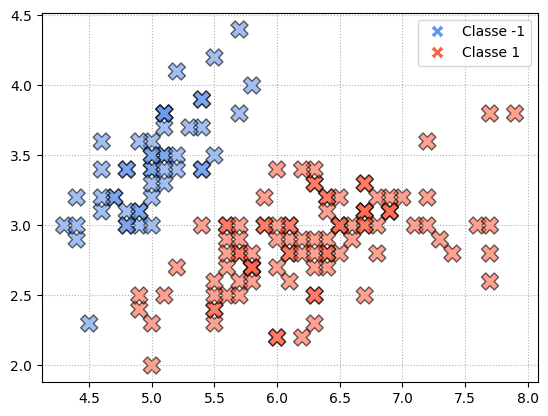

In [7]:
# definindo o color map
cmap_ = ListedColormap(['#6495ED', '#FF6347'])

# Plotagem para ver os dados
fig, ax = plt.subplots()
legend_elements = [
    Line2D(
        [0], [0], marker='X', color='w', markerfacecolor='#6495ED', 
        markersize=10, label='Classe -1'
    ),
    Line2D(
        [0], [0], marker='X', color='w', markerfacecolor='#FF6347', 
        markersize=10, label='Classe 1'
    )
]
ax.scatter(X[:, 0], X[:, 1], c=y, marker='X', s=150, cmap=cmap_, alpha=0.6, edgecolor='k')
ax.grid(True, linestyle=':')
# ax.set_xlim(3.8, 8.5)
# ax.set_ylim(1.8, 4.6)
ax.legend(handles=legend_elements)
plt.show()

In [8]:
# learning rate
LR = 0.1
EPOCHS = 30

In [9]:
IN_FEATURES = X.shape[1]

In [10]:
# criando uma estrutura para salver os pesos e biases
@dataclass
class Weights:
    W: Tensor | None = None
    b: Tensor | None = None
    in_features: int = IN_FEATURES

    def __post_init__(self):
        np.random.seed(SEED)
        if self.W is None:
            self.W = np.random.randn(self.in_features)
        if self.b is None:
            self.b = np.random.randn(1)

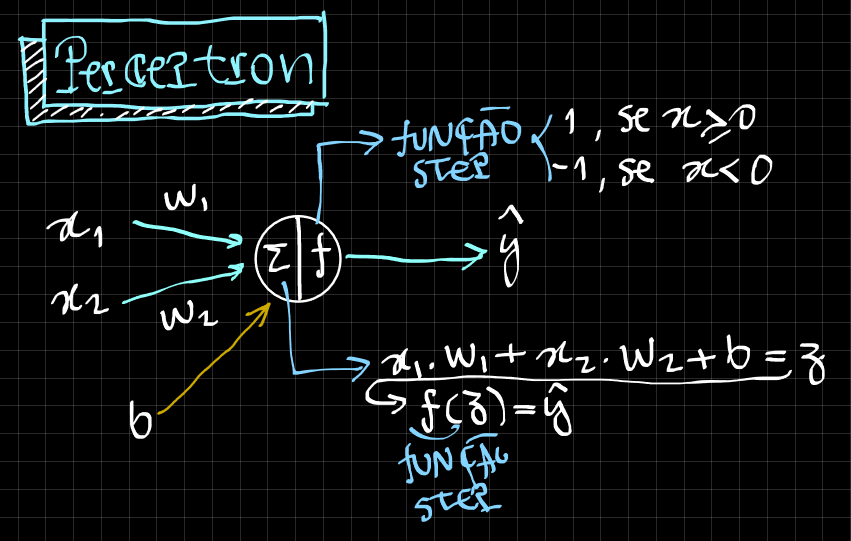

In [11]:
w = Weights()
print(w)

Weights(W=array([ 0.49671415, -0.1382643 ]), b=array([0.64768854]), in_features=2)


In [12]:
def step_activation_function(z: Tensor) -> Tensor:
    z = np.where(z >= 0, 1, -1)
    return z

def forward(weights: Weights, X: Tensor) -> Tensor:
    z = X @ weights.W + weights.b
    return step_activation_function(z)

In [13]:
def upgrade_weigths(
    weights: Weights,
    X: Tensor, 
    y: Tensor,
    lr: float
) -> Weights:
    y_hat = forward(weights, X)
    # filtra apenas pelos errados
    mask = (y != y_hat)
    X_wrong = X[mask]
    y_wrong = y[mask]

    new_weights = Weights(
        # TODO: X_wrong.T @ y_wrong? Porque isso acontece?
        W=weights.W + lr * (X_wrong.T @ y_wrong).flatten(),
        b=weights.b + lr * y_wrong.sum()
    )
    return new_weights

In [14]:
w = upgrade_weigths(w, X, y, LR)
w

Weights(W=array([-24.53328585, -17.2782643 ]), b=array([-4.35231146]), in_features=2)

In [15]:
def confusion_matrix_fn(y_true, y_hat) -> tuple[float, float, float, float]:
    # eram 1 e foram preditos corretamente 1 (y_true = 1 e y_hat = 1)
    tp = ((y_true == 1) & (y_hat == 1)).sum()
    # eram -1 e foram preditos corretamente -1 (y_true = -1 e y_hat = -1)
    tn = ((y_true == -1) & (y_hat == -1)).sum()
    # eram -1 e foram preditos incorretamente 1 (y_true = -1 e y_hat = 1)
    fp = ((y_true == -1) & (y_hat == 1)).sum()
    # eram 1 e foram preditos incorretamente -1 (y_true = 1 e y_hat = -1)
    fn = ((y_true == 1) & (y_hat == -1)).sum()
    return (tp, tn, fp, fn)

In [16]:
def accuracy_fn(y_true: Tensor, y_hat: Tensor) -> float:
    tp, tn, fp, fn = confusion_matrix_fn(y_true, y_hat)
    # de todas as previsões quais foram preditas corretamente
    acc = (tp + tn) / (tp + tn + fp + fn)
    acc = np.round(acc, 2).item()
    return acc

In [17]:
history = defaultdict(list)

for epoch in range(EPOCHS):
    w = upgrade_weigths(w, X, y, LR)
    if epoch % 2 == 0:
        y_hat = forward(w, X)
        acc = accuracy_fn(y, y_hat)
        history['weights'].append(w)
        history['accuracy'].append(acc)

In [18]:
y_hat = forward(w, X)

In [19]:
print('Erros e acertos perceptron:')
print((y == y_hat))

Erros e acertos perceptron:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [20]:
def decision_boundary(ax, weights, X, y, cmap):
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x1, x2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 100),
        np.linspace(x2_min, x2_max, 100)
    )
    X_grid = np.c_[x1.ravel(), x2.ravel()]
    y_hat = forward(weights, X_grid)
    y_hat = y_hat.reshape(x1.shape)
    
    ax.contourf(x1, x2, y_hat, levels=20, cmap=cmap, alpha=0.3)
    ax.contour(x1, x2, y_hat, levels=[0], colors='black', linewidths=2)
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=cmap, 
        marker='X',
        s=150,
        edgecolors='black'
    )
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')

In [21]:
anim = create_animation_plot(
    history=history,
    plot_func=decision_boundary,
    figsize=(10, 8),
    interval=300,
    title_prefix="Época",
    X=X,
    y=y,
    cmap='coolwarm'
)

In [28]:
anim.save("giffs/perceptron.gif", writer="pillow", fps=2)

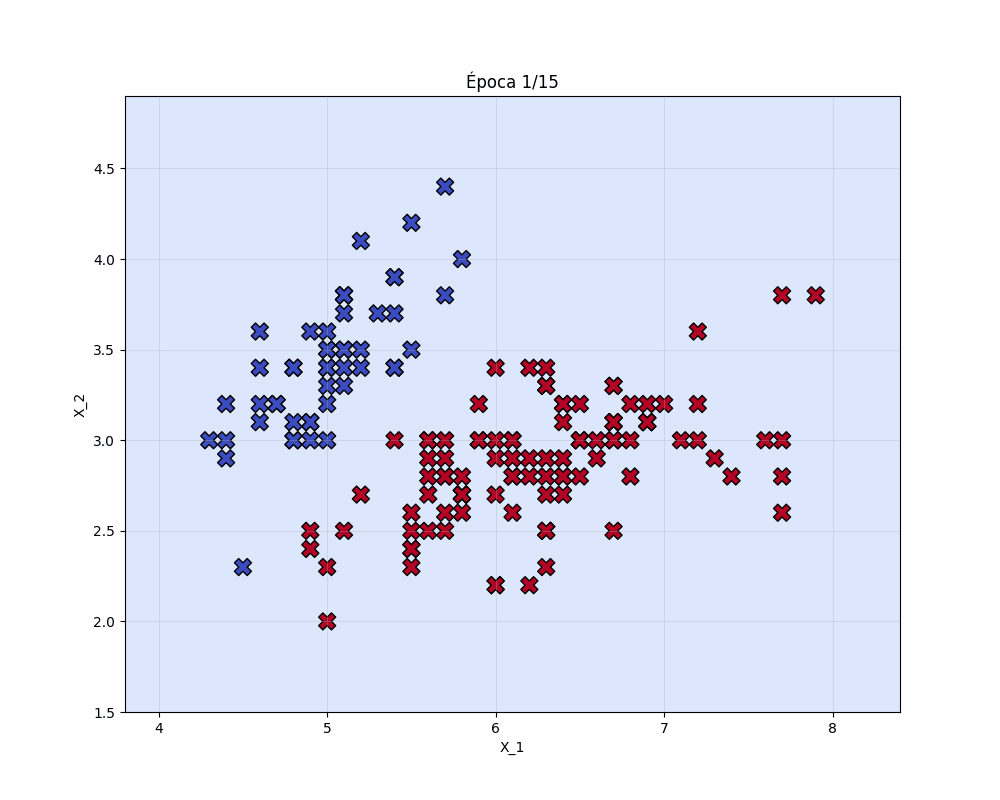

In [29]:
display(Image(filename="giffs/perceptron.gif"))

# Erros

In [31]:
# os dois pontos vermelhos na linha e o ponto azul
X[np.where((y == y_hat) == False)[0]]

array([[4.5, 2.3],
       [5.4, 3. ],
       [6. , 3.4]])

In [32]:
forward(w, X[np.where((y == y_hat) == False)[0]])

array([ 1, -1, -1])

In [33]:
y[np.where((y == y_hat) == False)[0]]

array([-1,  1,  1])